# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! unzip -qq /content/drive/MyDrive/hseds-texts-2020.zip -d hseds-texts-2020

In [2]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'

In [3]:
import numpy as np

In [4]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [5]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [7]:
df['common'] = df['negative'] + df['positive']

In [8]:
df['common']

0        [there, were, issues, with, the, wifi, connect...
1                         [tv, not, working, no, positive]
2        [more, pillows, beautiful, room, great, locati...
3                               [very, business, location]
4        [rooms, could, do, with, a, bit, of, a, refurb...
                               ...                        
99995    [no, coffee, facilities, in, room, air, con, d...
99996    [the, room, was, far, too, hot, on, the, first...
99997    [terrible, worn, out, mattress, dust, behind, ...
99998    [no, negative, very, profissional, and, nice, ...
99999    [no, negative, great, breakfast, and, the, roo...
Name: common, Length: 100000, dtype: object

In [9]:
# check for empty strings and values and remove empty ones (where both positive and negative reviews don't exists) because they are useless
df = df[df['common'].astype(bool)]

In [10]:
df.shape

(99993, 5)

In [11]:
X = df['common'].to_numpy()
y = df['score'].to_numpy()

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df) # for part 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18122020) # for part 1 & 2

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(69995,) (29998,)
(69995,) (29998,)


### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [177]:
from sklearn.metrics import mean_absolute_error

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [179]:
def identity_tokenizer(text):
    return text

In [180]:
tfidf = TfidfVectorizer(min_df=0.001, max_df=1.0, tokenizer=identity_tokenizer, lowercase=False)

In [181]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [182]:
print(tfidf_train.shape, tfidf_test.shape)

(69995, 1981) (29998, 1981)


In [183]:
%%time
linreg = LinearRegression()
linreg.fit(tfidf_train, y_train)
y_pred = linreg.predict(tfidf_test)

CPU times: user 1.14 s, sys: 898 ms, total: 2.03 s
Wall time: 1.07 s


In [184]:
print(mean_absolute_error(y_pred, y_test))
assert(mean_absolute_error(y_pred, y_test) < 1.0)

0.896265582729089


### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [185]:
from gensim.models import Word2Vec

In [186]:
tfidf_full = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
tfidf_full.fit_transform(X)

<99993x34728 sparse matrix of type '<class 'numpy.float64'>'
	with 2727997 stored elements in Compressed Sparse Row format>

In [187]:
idf_dict = dict(zip(tfidf_full.get_feature_names(), tfidf_full.idf_))
print(len(idf_dict))

34728


In [188]:
w2v = Word2Vec(X, size=300, sg=0)

In [189]:
w2v.wv.most_similar('bathroom')

[('toilet', 0.6952214241027832),
 ('bathtub', 0.6831605434417725),
 ('bath', 0.6750932335853577),
 ('bathrooms', 0.6529937386512756),
 ('bedroom', 0.6227940320968628),
 ('washroom', 0.6186593770980835),
 ('wardrobe', 0.6037397980690002),
 ('carpet', 0.5927545428276062),
 ('shower', 0.5878353118896484),
 ('closet', 0.5802087783813477)]

In [190]:
X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X, y, test_size=0.3, random_state=18122020)

In [191]:
print(X_w2v_train.shape, X_w2v_test.shape, y_w2v_train.shape, y_w2v_test.shape)

(69995,) (29998,) (69995,) (29998,)


In [192]:
def average_w2v(w2v, document, k=300, use_idf=False, gen_embedding=False):
  np.random.seed(20122020)
  weights = []
  document = [word for word in document if word in w2v.wv.vocab]
  
  if not document:
    if gen_embedding:
      return np.random.rand(k)

  if len(document) == 1:
    return w2v[document[0]]

  if use_idf:
    weights = np.array([idf_dict[word] for word in document if word in w2v.wv.vocab])
    assert(len(weights) == len(document))
    weights = weights.reshape(-1, 1)
    result = w2v[document] * weights
    assert(result.shape == w2v[document].shape)
    result = np.sum(result, axis=0)
    return result

  return np.mean(w2v[document], axis=0)

In [193]:
def GetSentenceEmbedding(w2v_dict, array: np.array, k=300, use_idf=False, gen_embedding=False):
  new = []
  invalid_indices = []
  for i in range(len(array)):
    try:
      tmp = average_w2v(w2v_dict, array[i], k, use_idf=use_idf, gen_embedding=gen_embedding)
      assert(len(tmp) == k)
      new.append(tmp)
    except ValueError as ve: # for non existing embeddings
      invalid_indices.append(i)
  return np.stack(np.array(new), axis=0), invalid_indices

In [194]:
w2v_train, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, gen_embedding=True)
w2v_test, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, gen_embedding=True)
y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
print(len(w2v_train), len(y_w2v_train))
print(len(w2v_test), len(y_w2v_test))
assert(len(w2v_train) == len(y_w2v_train))
assert(len(w2v_test) == len(y_w2v_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


69995 69995
29998 29998


In [195]:
assert(w2v_train.shape[1] == 300 and w2v_test.shape[1] == 300)

In [196]:
print(w2v_train.shape, w2v_test.shape)

(69995, 300) (29998, 300)


In [197]:
%%time 
lr_w2v = LinearRegression()
lr_w2v.fit(w2v_train, y_w2v_train)
y_w2v_pred = lr_w2v.predict(w2v_test)

CPU times: user 2.73 s, sys: 166 ms, total: 2.9 s
Wall time: 1.73 s


In [198]:
print(mean_absolute_error(y_w2v_pred, y_w2v_test))
assert(mean_absolute_error(y_w2v_pred, y_w2v_test) < 1.0)

1.0039565242926205


AssertionError: ignored

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [199]:
def calc_idf(texts):
    pass

In [200]:
w2v_train_idf, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, use_idf=True, gen_embedding=True)
w2v_test_idf, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, use_idf=True, gen_embedding=True)
y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
print(len(w2v_train_idf), len(y_w2v_train))
print(len(w2v_test_idf), len(y_w2v_test))
assert(len(w2v_train_idf) == len(y_w2v_train))
assert(len(w2v_test_idf) == len(y_w2v_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


69995 69995
29998 29998


In [201]:
assert(w2v_train.shape[1] == 300 and w2v_test.shape[1] == 300)

In [202]:
lr_w2v.fit(w2v_train_idf, y_w2v_train)
y_w2v_idf_pred = lr_w2v.predict(w2v_test_idf)

In [203]:
print(mean_absolute_error(y_w2v_idf_pred, y_w2v_test))
assert(mean_absolute_error(y_w2v_idf_pred, y_w2v_test) < 1.0)

0.9622350456653619


Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline

In [205]:
e_sizes = [50, 100, 200, 300, 400, 500, 1000]

In [206]:
def Train(e_sizes: list, seed: int=18122020, gen_embedding=False, use_idf=False):
  mae_results = []
  np.random.seed(seed)
  for k in e_sizes:
    print("Case: k = %d" % k)
    print("Training Word2Vec embeddings...")
    w2v = Word2Vec(X, size=k, sg=0)
    print("Finished Training\n")
    X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    print("Getting Sentence Embeddings...")
    w2v_train, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, k=k, use_idf=use_idf, gen_embedding=gen_embedding)
    w2v_test, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, k=k, use_idf=use_idf, gen_embedding=gen_embedding)
    y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
    y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
    assert(len(w2v_train) == len(y_w2v_train))
    assert(len(w2v_test) == len(y_w2v_test))
    assert(w2v_train.shape[1] == k and w2v_test.shape[1] == k)
    print("Finished Getting Sentence Embeddings\n")

    print("Performing Linear Regression")
    lr_w2v = LinearRegression()
    lr_w2v.fit(w2v_train, y_w2v_train)
    y_w2v_pred = lr_w2v.predict(w2v_test)
    print("k = %d, mae: %.8f" % (k, mean_absolute_error(y_w2v_pred, y_w2v_test)))

    mae_results.append(mean_absolute_error(y_w2v_pred, y_w2v_test))
    print("Finished training for k = %d\nMoving On...\n\n" % k)
  return mae_results

In [207]:
mae_results = Train(e_sizes, gen_embedding=True, use_idf=True)

Case: k = 50
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 50, mae: 1.04950709
Finished training for k = 50
Moving On...


Case: k = 100
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 100, mae: 1.01572996
Finished training for k = 100
Moving On...


Case: k = 200
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 200, mae: 0.97345808
Finished training for k = 200
Moving On...


Case: k = 300
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 300, mae: 0.96378616
Finished training for k = 300
Moving On...


Case: k = 400
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 400, mae: 0.94896773
Finished training for k = 400
Moving On...


Case: k = 500
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 500, mae: 0.94629324
Finished training for k = 500
Moving On...


Case: k = 1000
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 1000, mae: 0.93128121
Finished training for k = 1000
Moving On...




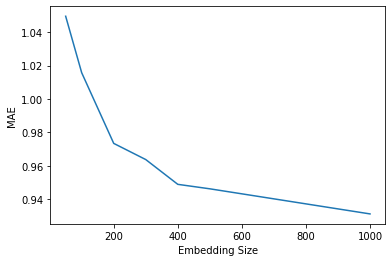

In [208]:
plt.plot(e_sizes, mae_results)
plt.xlabel("Embedding Size")
plt.ylabel("MAE")
plt.show()

In [209]:
mae_results_no_idf = Train(e_sizes, gen_embedding=True, use_idf=False)

Case: k = 50
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 50, mae: 1.06776169
Finished training for k = 50
Moving On...


Case: k = 100
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 100, mae: 1.03508442
Finished training for k = 100
Moving On...


Case: k = 200
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 200, mae: 1.01204926
Finished training for k = 200
Moving On...


Case: k = 300
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 300, mae: 1.00495397
Finished training for k = 300
Moving On...


Case: k = 400
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 400, mae: 0.99681727
Finished training for k = 400
Moving On...


Case: k = 500
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 500, mae: 0.99298324
Finished training for k = 500
Moving On...


Case: k = 1000
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 1000, mae: 0.97986941
Finished training for k = 1000
Moving On...




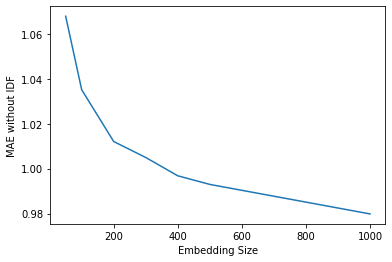

In [210]:
plt.plot(e_sizes, mae_results_no_idf)
plt.xlabel("Embedding Size")
plt.ylabel("MAE without IDF")
plt.show()

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.


In [ ]:
from gensim.models import FastText

In [ ]:
ft = FastText(X, size=300, min_n=3, max_n=8, seed=18122020, iter=20)
X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X, y, test_size=0.3, random_state=18122020)

In [ ]:
def average_ft(ft, document):
  np.random.seed(20122020)
  weights = []
  document = [word for word in document if word in ft.wv.vocab]

  if not document:
    return np.zeros(300)

  if len(document) == 1:
    return ft[document[0]]


  return np.mean(ft[document], axis=0)

In [ ]:
def FTGetSentenceEmbedding(ft, array):
  new = []
  invalid_indices = []
  for i in range(len(array)):
      tmp = average_ft(ft, array[i])
      assert(len(tmp) == 300)
      new.append(tmp)
  return np.stack(np.array(new), axis=0)

In [ ]:
ft_train = FTGetSentenceEmbedding(ft, X_ft_train)
ft_test = FTGetSentenceEmbedding(ft, X_ft_test)
print(len(ft_train), len(y_ft_train))
print(len(ft_test), len(y_ft_test))
assert(len(ft_train) == len(y_ft_train))
assert(len(ft_test) == len(y_ft_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


69995 69995
29998 29998


In [ ]:
lr_ft = LinearRegression()
lr_ft.fit(ft_train, y_ft_train)
y_pred_ft = lr_ft.predict(ft_test)

In [ ]:
print(mean_absolute_error(y_pred_ft, y_ft_test))
assert(mean_absolute_error(y_pred_ft, y_ft_test) < 1.0)

0.9988481218912844


#### Выводы:


Относительно Word2Vec Эмбеддингов получаем следующую картину:

Embedding'и, взвешенные с помощью IDF, дают более качественный результат, поскольку IDF достаточно точно показывает то, сколько информации несет в себе каждое слово в данном корпусе (является ли оно редким или частым). Частые слова получают больший вес, редкие – меньший. Казалось бы, но размер Embedding'a имеет значение: чем он больше, тем более меньший loss. Это наблюдается в при обоих случаях.

По поводу сравнения разных embedding'ов можно сказать, что данный корпус является не очень большим, и словарь у нас тоже не очень большой.
Можно заметить, что FastText и Word2Vec перформят примерно одинаково, с некоторым перевесом в сторону Word2Vec'а, что странно. Важную роль играет предобработка текста. В моем случае, она стандартная и не очень качественная. Возможно, что FastText будет проявлять себя лучше на предобработанных более качественно данных.

На самом деле разница между Word2Vec и FastText заключается в подходе к представлению слов:
FastText представляет возможность более качественного анализа и теоретически и практически должен давать лучший по сравнению с W2v результат, поскольку он позволяет рассматривать слова как марковские цепи или n-грамы (в компьютерной лингвистике). Таким образом каждое слово в FastText может быть представлено в виде цепочки подслов. Эти цепочки подслов могут быть использованы для того, чтобы создавать эмбеддинги для странных, причудливых, редких слов довольно содержащих в себе известные подслова. Это вектора в n-мерном пространстве, угол (косинусная близость)между которыми вследствие такой генерации будет меньшим, чем если генерировать наобум известного хорошего распредедения (это наверное можно показать формально). Так как наш текст не очень богат на слова и в следствие плохой обработки FastText не дает сравнительного буста в качестве.

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import sys

In [15]:
torch.tensor(df_train['score'].values, dtype=torch.float)[[0, 1]]

tensor([5.8000, 8.8000])

In [16]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [98]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [99]:
print(len(int2word), len(word2int))

34728 34728


In [114]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))

In [115]:
MAX_LEN

399

In [116]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

In [117]:
type(train_pos_pad)

torch.Tensor

In [171]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        ## TODO
        #self.reviews = df['common'].to_numpy() # type: np.array
        #self.int2word = dict(enumerate(tuple(WORDS))) # (idx, word) lookup
        #self.word2int = {w: ii for ii, w in int2word.items()} # (word, idx) lookup
        self.scores = torch.tensor(df['score'].values, dtype=torch.float) # torch.tensor, 32bit accuracy is more than enough
        self.padded_idx = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df['common']], 
                           batch_first=True)
        
    def __len__(self):
        ## TODO
        return len(self.scores)
    
    def __getitem__(self, idx):
        ## TODO
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.padded_idx[idx], self.scores[idx] # (np.array, tensor) - tokenized sentences and corresponding rating


In [172]:
BATCH_SIZE = 32

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

In [173]:
class RNNRegressor(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNRegressor, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)

        self.regression = nn.Linear(hidden_dim * MAX_LEN, 1) # return one score (float)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        fc_out = self.regression(torch.flatten(lstm_out, start_dim=1))
        return fc_out.reshape(-1)

In [174]:
model = RNNRegressor(len(word2int), 1000, 50)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.005)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [175]:
def train(train_dataloader, criterion, optimizer, device="cuda:0"):
  model.train()
  loss_history = []
  with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
    for (idx, score) in train_dataloader:
      #idx = pack_padded_sequence(idx, MAX_LEN, batch_first=True, enforce_sorted=False)
      idx = idx.to(device)
      score = score.to(device)
      pred_score = model(idx)
      optimizer.zero_grad()
      loss = criterion(pred_score, score)
      loss.backward()
      optimizer.step()
      prbar.set_description(
            "batch mae: %.4f" % (loss.item())
        )
      loss_history.append(loss.item())
      prbar.update(1)
  return np.mean(np.array(loss_history)) # mean loss
    


In [176]:
NUM_EPOCHS = 30
losses = []
for i in range(NUM_EPOCHS):
  loss_test = []
  mae_mean = train(train_dataloader, criterion, optimizer, device=device)
  
  with torch.no_grad():
    with tqdm(total=len(test_dataloader), file=sys.stdout) as prbar:
      for (idx, score) in test_dataloader:
        #idx_packed = pack_padded_sequence(idx, MAX_LEN, batch_first=True, enforce_sorted=False)
        idx = idx.to(device)
        score = score.to(device)
        pred_score = model(idx)
        loss = criterion(pred_score, score)
        prbar.set_description(
            "epoch mae: %.4f" % (loss.item())
        )
        prbar.update(1)
        loss_test.append(loss.item())
  epoch_loss = sum(loss_test) / len(loss_test)
  losses.append(epoch_loss)
  print("cur epoch mae: %.8f" % (epoch_loss))
  

epoch mae: 1.6412: 100%|██████████| 3125/3125 [00:41<00:00, 74.45it/s]
cur epoch mae: 0.99819551
epoch mae: 1.6891: 100%|██████████| 3125/3125 [00:41<00:00, 74.46it/s]
cur epoch mae: 1.01731824
epoch mae: 1.6173: 100%|██████████| 3125/3125 [00:41<00:00, 74.58it/s]
cur epoch mae: 0.95010458
epoch mae: 1.5586: 100%|██████████| 3125/3125 [00:42<00:00, 73.75it/s]
cur epoch mae: 0.93719646
epoch mae: 1.4732: 100%|██████████| 3125/3125 [00:41<00:00, 74.60it/s]
cur epoch mae: 0.91986733
epoch mae: 1.4582: 100%|██████████| 3125/3125 [00:43<00:00, 72.57it/s]
cur epoch mae: 0.90925621
epoch mae: 1.4090: 100%|██████████| 3125/3125 [00:42<00:00, 73.74it/s]
cur epoch mae: 0.89814038
epoch mae: 1.3818: 100%|██████████| 3125/3125 [00:42<00:00, 73.94it/s]
cur epoch mae: 0.87619216
epoch mae: 1.3390: 100%|██████████| 3125/3125 [00:42<00:00, 73.88it/s]
cur epoch mae: 0.88280076
epoch mae: 1.4134: 100%|██████████| 3125/3125 [00:42<00:00, 74.08it/s]
cur epoch mae: 0.87977908
epoch mae: 1.3234: 100%|██████

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.